In [1]:
from pmotifs.analysis_utilities.loading import Result
from pmotifs.config import config

GRAPHLET_SIZE = 3

r = Result.load_result(
    config.DATASET_DIRECTORY /  "yeastInter_st.txt",
    config.EXPERIMENT_OUT / "yeastInter_st",
    GRAPHLET_SIZE,
)

g = r.pmotif_graph
df = r.positional_metric_df

Loading graph modules: 100%|████████████████| 27/27 [00:00<00:00, 352791.93it/s]


In [2]:
randomized_results = Result.load_randomized_results(g, GRAPHLET_SIZE, supress_tqdm=True)

Loading Randomized Results: 100%|███████████| 1000/1000 [00:45<00:00, 21.94it/s]


In [3]:
from pmotifs.analysis_utilities.metric_consolidation import metrics

potential_metrics = metrics.keys()
potential_metrics

dict_keys(['max normalized anchor hop distance', 'min normalized anchor hop distance', 'mean normalized anchor hop distance', 'graph module participation ratio', 'degree'])

In [4]:
METRIC_NAME = "graph module participation ratio"

assert METRIC_NAME in potential_metrics

In [5]:
from typing import Union

from pmotifs.GraphletPositionalMetrics import GraphletPositionalMetrics


def get_positional_metric(result: Result) -> Union[int, float]:
    """A wrapper to consolidate metrics"""
    return metrics[METRIC_NAME](result)

In [6]:
df[METRIC_NAME] = get_positional_metric(r)

In [7]:
for r in randomized_results:
    r.positional_metric_df[METRIC_NAME] = get_positional_metric(r)

randomized_results = {
    r.pmotif_graph: r.positional_metric_df
    for r in randomized_results
}

# Analysis

In [8]:
# Extract Distribution of Metric for one dataframe
def extract_metric_distribution(df, metric_name):
    return dict(df.groupby("graphlet_class").agg(list)[metric_name])

extract_metric_distribution(df, METRIC_NAME)

{'011 100 100': [0.037037037037037035,
  0.07407407407407407,
  0.07407407407407407,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.07407407407407407,
  0.037037037037037035,
  0.07407407407407407,
  0.037037037037037035,
  0.037037037037037035,
  0.07407407407407407,
  0.037037037037037035,
  0.037037037037037035,
  0.07407407407407407,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.07407407407407407,
  0.07407407407407407,
  0.037037037037037035,
  0.037037037037037035,
  0.07407407407407407,
  0.037037037037037035,
  0.07407407407407407,
  0.07407407407407407,
  0.07407407407407407,
  0.07407407407407407,
  0.07407407407407407,
  0.1111111111111111,
  0.07407407407407407,
  0.07407407407407407,
  0.1111111111111111,
  0.07407407407407407,
  0.07407407407407407,
  0.07407407407407407,
  0.07407407407407407,
  0.07407407407407407,
  

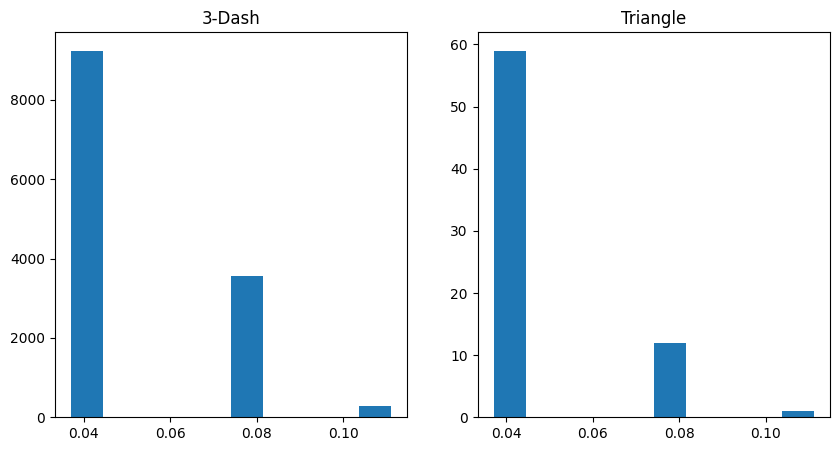

In [9]:
from pmotifs.graphlet_representation import graphlet_class_to_name

import matplotlib.pyplot as plt

def plot_distirbution_per_class(df, metric_name):
    distributions = extract_metric_distribution(df, metric_name)
    fig, axes = plt.subplots(1, len(distributions), figsize=(5*len(distributions), 5))
    
    for i, graphlet_class in enumerate(distributions.keys()):
        ax = axes[i]
        ax.hist(distributions[graphlet_class])
        ax.set_title(graphlet_class_to_name(graphlet_class))
    # return fig

plot_distirbution_per_class(df, METRIC_NAME)

In [10]:
graphlet_classes = list(df.groupby("graphlet_class").agg(lambda i: None).index)
graphlet_classes

['011 100 100', '011 101 110']

In [11]:
from scipy.stats import mannwhitneyu
from statistics import median
from tqdm import tqdm
import pandas as pd

original_distribution = extract_metric_distribution(df, METRIC_NAME)

data = {}
for graphlet_class in graphlet_classes:
    data[graphlet_class] = []
    for r_df in tqdm(randomized_results.values()):
        random_distribution = extract_metric_distribution(r_df, METRIC_NAME)

        mwu_result = mannwhitneyu(
            original_distribution[graphlet_class],
            random_distribution[graphlet_class],
        )

        data[graphlet_class].append({
           "u-statistic": mwu_result.statistic,
           "p-value": mwu_result.pvalue,
           "sample-size": len(random_distribution[graphlet_class]),
           "sample-median": median(random_distribution[graphlet_class]),
           "original-size": len(original_distribution[graphlet_class]),
           "original-median": median(original_distribution[graphlet_class]),
       })

result_dfs = {
    graphlet_class: pd.DataFrame(d)
    for graphlet_class, d in data.items()
}

100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 136.10it/s]


In [12]:
def echo_results(df, alpha_global=0.05):
    # Bonferroni Correction
    alpha_local = alpha_global / df.shape[0]

    rejected_rows = df[df["p-value"] < alpha_local]
    print(f"The original is not like the random in {rejected_rows.shape[0]} of {df.shape[0]} cases!")

In [13]:
import matplotlib.pyplot as plt

def plot_results(df, graphlet_class):
    fig, (size_ax, median_ax) = plt.subplots(1,2, figsize=(10, 5))

    df[["sample-size"]].plot.hist(ax=size_ax)
    size_ax.axvline(result_df["original-size"][0], label="original", color="tab:orange")
    size_ax.set_title("sample-size")
    size_ax.legend()
    size_ax.set_xlabel(METRIC_NAME)

    df[["sample-median"]].plot.hist(ax=median_ax)
    median_ax.axvline(result_df["original-median"][0], label="original", color="tab:orange")
    median_ax.set_title("sample-median")
    median_ax.legend()
    median_ax.set_xlabel(METRIC_NAME)
    
    fig.suptitle(graphlet_class_to_name(graphlet_class))

3-Dash
The original is not like the random in 1000 of 1000 cases!

Triangle
The original is not like the random in 399 of 1000 cases!



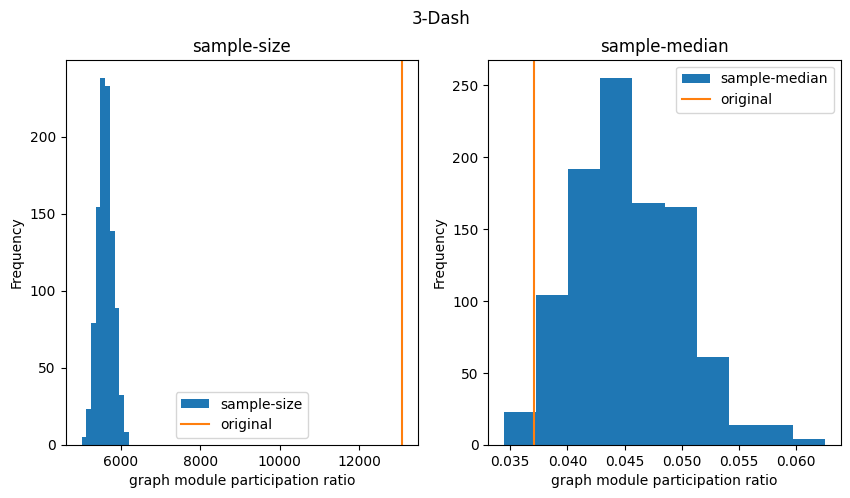

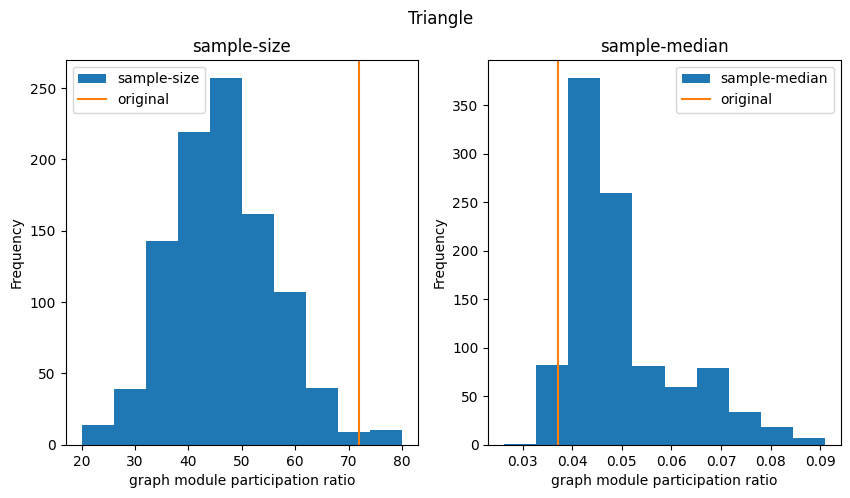

In [14]:
for graphlet_class, result_df in result_dfs.items():
    print(graphlet_class_to_name(graphlet_class))
    echo_results(result_df)
    plot_results(result_df,graphlet_class)
    print()